In [1]:
import keras
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import pickle
import sbibm
import torch

# Plotting settings
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.labelsize"] = "medium"
mpl.rcParams["legend.frameon"] = False
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["font.size"] = 20

# Fix seed 
seed = 57637 #torch.randint(1000000, (1,))
torch.manual_seed(seed)
print(f"seed {seed}")

seed 57637


## Load DDM task from `sbibm`

In [2]:
task = sbibm.get_task("ddm")
prior = task.get_prior_dist()
simulator = task.get_simulator(seed=seed) # Passing the seed to Julia.

### Load pretrained LANs

In [3]:
# network trained on KDE likelihood for 4-param ddm
lan_kde_path = "../sbibm/algorithms/lan/lan_pretrained/model_final_ddm.h5"
lan_ana_path = "../sbibm/algorithms/lan/lan_pretrained/model_final_ddm_analytic.h5"
lan_kde = keras.models.load_model(lan_kde_path, compile=False)
lan_ana = keras.models.load_model(lan_ana_path, compile=False)

def lan_likelihood(theta, data, net, ll_lower_bound):
    """Return log likelihood summed over all trials in data, 
        given a batch of parameters theta.
    
    Args
        theta: batch of parameters
        data: batch of iid reaction times and choices encoded
            as negative and positive reaction times. 
        net: lan keras model
        ll_lower_bound: lower bound of single trial log likelihood.
        
    Returns
        llsum: batch of log likelihoods over trials. 
    """
    
    # Convert to positive rts.
    rts = abs(data)
    num_trials = rts.numel()
    num_parameters = theta.shape[0]
    assert rts.shape == torch.Size([num_trials, 1])
    theta = torch.tensor(theta, dtype=torch.float32)
    # Convert DDM boundary seperation to symmetric boundary size.
    theta[:, 1] *= 0.5

    # Code down -1 up +1.
    cs = torch.ones_like(rts)
    cs[data < 0] *= -1

    # Repeat theta trial times
    theta_repeated = theta.repeat(num_trials, 1)
    # repeat trial data theta times.
    rts_repeated = torch.repeat_interleave(rts, num_parameters, dim=0)
    cs_repeated = torch.repeat_interleave(cs, num_parameters, dim=0)

    # stack everything for the LAN net.
    theta_x_stack = torch.cat((theta_repeated, rts_repeated, cs_repeated), dim=1)
    ll_each_trial = torch.tensor(
        net.predict_on_batch(theta_x_stack.numpy()),
        dtype=torch.float32,
    ).reshape(num_trials, num_parameters)

    # Lower bound on each trial log likelihood.
    # Sum across trials.
    llsum = torch.where(
        torch.logical_and(
            rts.repeat(1, num_parameters) > theta[:, -1], 
            ll_each_trial > ll_lower_bound,
        ),
        ll_each_trial,
        ll_lower_bound * torch.ones_like(ll_each_trial),
    ).sum(0)
    
    return llsum

## Likelihood comparison for single example

##### Sample example parameter from prior

For creating a figure showing the likelihood over the entire data space given a fixed parameter combination we sample a single parameter combination from the prior and evaluate the synthetic likelihoods for a large range of reaction times and both choices, while holding the parameters fixed.

In [4]:
# Sample one parameter from the prior for a likelihood example.
theta_o = prior.sample((1,))
l_lower_bound = 1e-7
theta_o

tensor([[1.3266, 1.0394, 0.6262, 0.4935]])

In [5]:
# Load pretrained NLE model
with open("../sbibm/algorithms/lan/nle_pretrained/mm93.p", "rb") as fh: 
    nle = pickle.load(fh)

In [6]:
# construct rts and choices for nle in [-test_tmax, test_tmax]

# RT range
test_tmax = 5
# Number of test points
ntest = 1000
rs = torch.cat((torch.linspace(test_tmax, 1e-7, ntest//2), 
           torch.linspace(1e-7, test_tmax, ntest//2))).reshape(-1, 1)
cs = torch.cat((torch.zeros(ntest//2), 
           torch.ones(ntest//2))).reshape(-1, 1)

test_rts = torch.linspace(-test_tmax, test_tmax, ntest)

# get NLE synthetic likelihood for each data point with fixed theta.
lps_nle = torch.tensor([nle.log_prob(r.reshape(-1, 1), c.reshape(-1, 1), theta_o) for r, c in zip(rs, cs)])

# from analytical likelihood
lps_true = torch.tensor([task.get_log_likelihood(theta_o, d.reshape(-1, 1), l_lower_bound=l_lower_bound) 
                     for d in test_rts])

# and from both LANs.
lps_lanana = torch.tensor([lan_likelihood(theta_o, 
                                   d.reshape(-1, 1), 
                                   net=lan_ana, 
                                   ll_lower_bound=np.log(l_lower_bound)) 
                    for d in test_rts])
lps_lankde = torch.tensor([lan_likelihood(theta_o, 
                                   d.reshape(-1, 1), 
                                   net=lan_kde, 
                                   ll_lower_bound=np.log(l_lower_bound)) 
                    for d in test_rts])

/home/janfb/.local/lib/python3.7/site-packages/julia/core.py:691: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  FutureWarning,
/home/janfb/anaconda3/envs/ddm/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


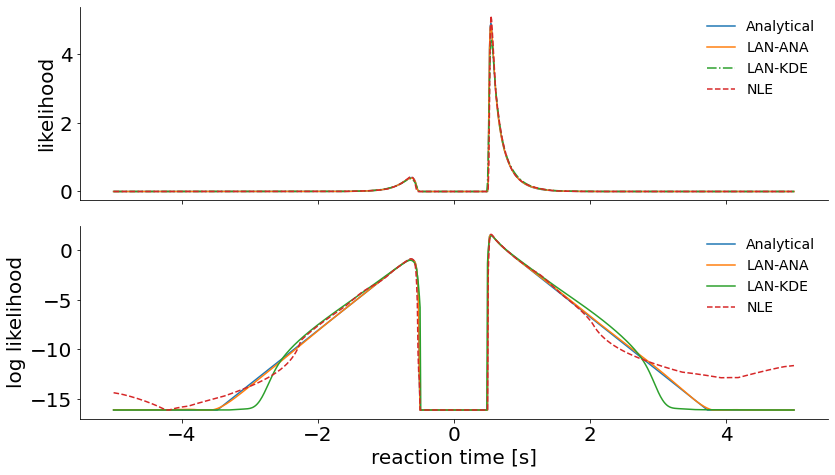

In [7]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 7))

labels = ["Analytical", 
          "LAN-ANA", 
          "LAN-KDE", 
          "NLE", 
         ]

plt.sca(ax[0])
plt.plot(test_rts, lps_true.exp(), label="Analytical L");
plt.plot(test_rts, lps_lanana.exp(), label="LAN-ANA");
plt.plot(test_rts, lps_lankde.exp(), label="LAN-KDE", ls="-.", c="C2");
plt.plot(test_rts, lps_nle.exp(), label="NLE", ls="--", c="C3");
plt.ylabel("likelihood")
plt.legend(labels)
# plt.suptitle(fr"v={theta_o[0, 0]:.2f}, a={theta_o[0, 1]:.2f}, w={theta_o[0, 2]:.2f}, $\tau$={theta_o[0, 3]:.2f}");

plt.sca(ax[1])
plt.plot(test_rts, lps_true)
plt.plot(test_rts, lps_lanana)
plt.plot(test_rts, lps_lankde, c="C2")
plt.plot(test_rts, lps_nle, ls="--", c="C3")
plt.legend(labels)
plt.xlabel("reaction time [s]")
plt.ylabel("log likelihood");
plt.tight_layout()
# fig.savefig("likelihood_example.png", dpi=300, bbox_inches="tight")

## Systematic Likelihood comparison

Next we do a systematic comparison based on the Huber loss (the LAN training loss) and the mean squared error (MSE) between analytical and synthetic log likelihoods of LAN and NLE.

To mimick the inference setup we sample an observation from the simulator via parameters from the prior and obtain the likelihood of this observation given a large batch of parameters, e.g., `1000`, sampled from the prior. The Huber loss and MSE is then calculated across this batch, giving a single number. This procedure we repeat for many observation, e.g., `100` and then show boxplots over the resulting 100 numbers. 

In [8]:
# Define losses.
def huberloss(y, yhat):
    diff = abs(y-yhat)
    
    err = np.zeros(y.numel())
    err[diff <= 1.0] = 0.5 * diff[diff <= 1.0]**2
    err[diff > 1.0] = 0.5 + diff[diff > 1.0]
    return err.mean()

def mse(y, yhat):
    return torch.mean((y - yhat)**2)

In [9]:
# mimick the MCMC setting: xo is fixed, thetas are scored with loss
num_observations = 100
num_thetas_per_observation = 1000

# first sample observations xo
xos = simulator(prior.sample((num_observations,)))

labels = [
    "LAN-ANA", 
    "LAN-KDE", 
    "NLE",
]
errors = []
for xo in xos:
    
    # Sample test thetas from prior.
    test_thetas = prior.sample((num_thetas_per_observation,))
    xo = xo.reshape(-1, 1)
    # Extract positive RTs and choices for mixed model.
    rs = abs(xo)
    cs = torch.ones_like(rs)
    cs[xo < 0] = 0

    # Evaluate
    lps_nle = nle.log_prob(rs, cs, test_thetas).squeeze()    
    lps_true = task.get_log_likelihood(test_thetas, data=xo.reshape(1, -1), l_lower_bound=l_lower_bound)
    lps_lanana = lan_likelihood(test_thetas, xo, lan_ana, np.log(l_lower_bound))
    lps_lankde = lan_likelihood(test_thetas, xo, lan_kde, np.log(l_lower_bound))
    

    # Score
    errors.append([
            [
                huberloss(lps_lanana, lps_true),
                huberloss(lps_lankde, lps_true),
                huberloss(lps_nle, lps_true),
            ],
            [
                huberloss(lps_lanana.exp(), lps_true.exp()),
                huberloss(lps_lankde.exp(), lps_true.exp()),
                huberloss(lps_nle.exp(), lps_true.exp()),
            ],            
            [
                mse(lps_lanana, lps_true),
                mse(lps_lankde, lps_true),
                mse(lps_nle, lps_true),
            ], 
            [
                mse(lps_lanana.exp(), lps_true.exp()),
                mse(lps_lankde.exp(), lps_true.exp()),
                mse(lps_nle.exp(), lps_true.exp()),
            ],         
        ])
errors = np.array(errors)

/home/janfb/anaconda3/envs/ddm/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [10]:
# extract separate dataframes for huber and mse.
dfhuber_log = pd.DataFrame(data=np.array(errors)[:, 0, :], columns=labels)
dfhuber = pd.DataFrame(data=np.array(errors)[:, 1, :], columns=labels)
dfmse_log = pd.DataFrame(data=np.array(errors)[:, 2, :], columns=labels)
dfmse = pd.DataFrame(data=np.array(errors)[:, 3, :], columns=labels)

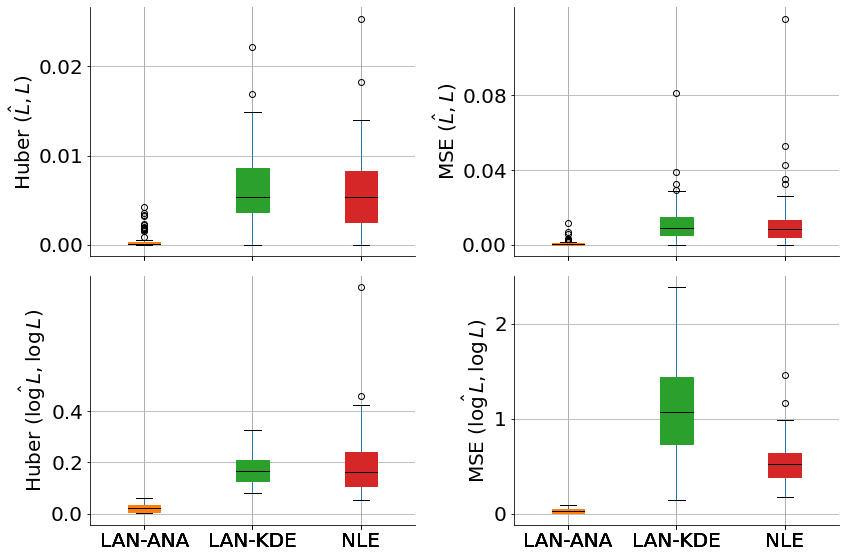

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
mpl.rcParams["legend.fontsize"] = 12
mpl.rcParams["font.size"] = 15
colors = ["C1", "C2", "C3"]
grid = True

# Plot Huber loss boxplot
plt.sca(ax[0, 0])
bdict = dfhuber.boxplot(ax=ax[0, 0], patch_artist=True, return_type="dict", 
                        medianprops={"color": "k"}, grid=grid)
plt.ylabel("Huber $(\hat{L}, L)$");
for i,box in enumerate(bdict['boxes']):
    box.set_color(colors[i])
plt.yticks(np.linspace(0, 0.02, 3));

plt.sca(ax[1, 0])
bdict = dfhuber_log.boxplot(ax=ax[1, 0], patch_artist=True, return_type="dict", 
                        medianprops={"color": "k"}, grid=grid)
plt.ylabel("Huber $(\hat{\log L}, \log L)$");
for i,box in enumerate(bdict['boxes']):
    box.set_color(colors[i])
plt.yticks(np.linspace(0, 0.4, 3));

# Plot MSE boxplot
plt.sca(ax[0, 1])
bdict = dfmse.boxplot(ax=ax[0, 1], patch_artist=True, return_type="dict", 
                      medianprops={"color": "k"}, grid=grid);
for i,box in enumerate(bdict['boxes']):
    box.set_color(colors[i])
plt.ylabel(r"MSE $(\hat{L}, L)$")
plt.yticks(np.linspace(0, 0.08, 3));

plt.sca(ax[1, 1])
bdict = dfmse_log.boxplot(ax=ax[1, 1], patch_artist=True, return_type="dict", 
                      medianprops={"color": "k"}, grid=grid);
for i,box in enumerate(bdict['boxes']):
    box.set_color(colors[i])
plt.ylabel(r"MSE $(\hat{\log L}, \log L)$");
plt.yticks(np.linspace(0, 2., 3));
plt.tight_layout()
# fig.savefig("likelihood_comparison.png", dpi=300, bbox_inches="tight")

## Visualize Likelihood for 10 Benchmark observations
We can also visualize the single trial likelihoods for the 10 random observations used in the benchmark.

In [12]:
ll_true = []
ll_lan = []
ll_nle = []

for ii in range(1, 11):
    
    xo = task.get_observation(ii).reshape(-1, 1)
    test_thetas = prior.sample((1000,))

    # Extract positive RTs and choices for mixed model.
    rs = abs(xo)
    cs = torch.ones_like(rs)
    cs[xo < 0] = 0
  
    ll_true.append(task.get_log_likelihood(test_thetas, data=xo.reshape(1, -1), l_lower_bound=l_lower_bound))

    ll_lan.append(lan_likelihood(test_thetas, 
                                xo, 
                                net=lan_kde, 
                                ll_lower_bound=np.log(l_lower_bound)))
    
    ll_nle.append(nle.log_prob(rs, cs, test_thetas))

/home/janfb/anaconda3/envs/ddm/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


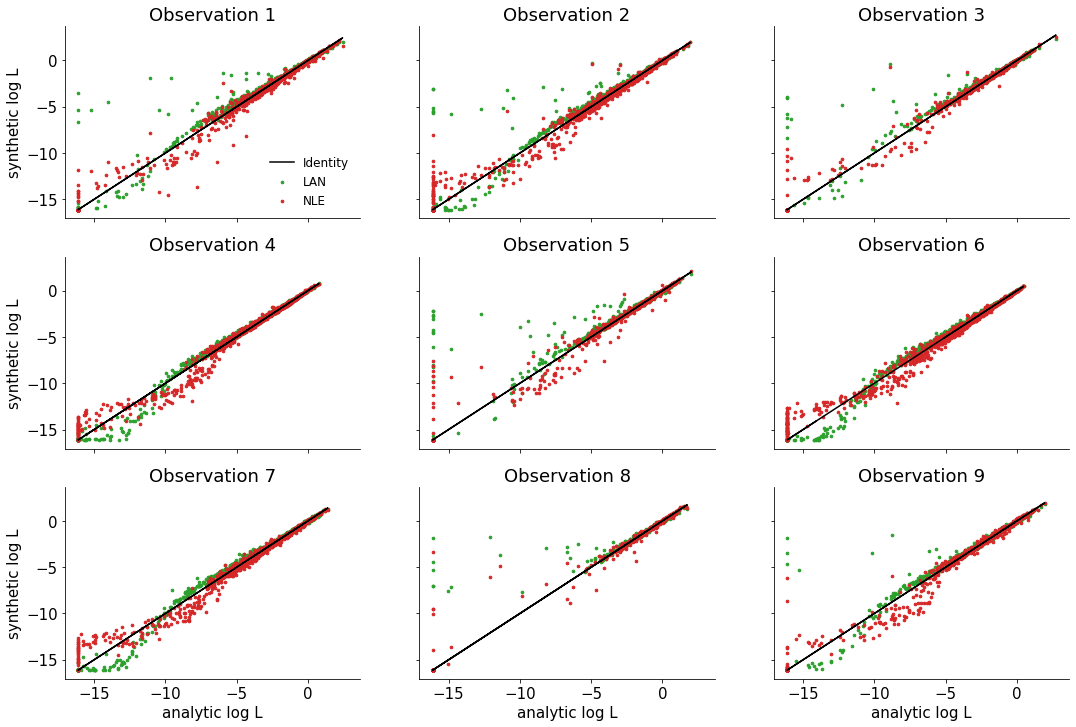

In [13]:
fig, ax = plt.subplots(3, 3, figsize=(18, 12), sharey=True, sharex=True)
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
s = 7
idx = 0
alpha = 1.0
for ii in range(0, 9):
    if ii%3 == 0:
        plt.sca(ax[idx, 0])
    elif ii%3 == 1:
        plt.sca(ax[idx, 1])
    elif ii%3 == 2:
        plt.sca(ax[idx, 2])
        idx += 1

    plt.title(f"Observation {ii+1}")
    
    plt.scatter(ll_true[ii], ll_lan[ii], alpha=alpha, color="C2", s=s)
    plt.scatter(ll_true[ii], ll_nle[ii], alpha=alpha, color="C3", s=s)
    plt.plot(ll_true[ii], ll_true[ii], "k")
    if not ii:
        plt.legend(["Identity", "LAN", "NLE", 
                   ], frameon=False, fontsize=12)
    if ii in [0, 3, 6]:
        plt.ylabel("synthetic log L")
    if ii > 5: 
        plt.xlabel("analytic log L")